In [1]:
# Выполнение одного набора xgbooster (JPG, либо TIF) (2017-07-03)

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skm
from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
import xgboost as xgb

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [51]:
sys.path.append('../Python')
from helper import paths_input, formImExt, formImHist
from estimate import confusion_matrix, getConfusion, getRocAUC, getProb01, estimateResult

In [8]:
trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
trWork, teWork = '../Work/Train', '../Work/Test'
print (trWork, teWork)
print (trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG)

../Work/Train ../Work/Test
../Data/train_v2.csv ../Data/train-tif-v2 ../Data/train-jpg ../Data/test-tif-v2 ../Data/test-jpg-v2


In [9]:
labels_df = pd.read_csv(trLabels)
labels_df.head(2)

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water


In [10]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [11]:
# Add features (0 or 1) for every label as dataframe field 
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
#labels_df.head()

In [12]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [13]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
#labelList[:6,:]
labels_df.head(2)

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
# Данные для обработки
binsData = 64
jpgtif   = '.jpg'
trX      = np.load('../Data-XGB/Datas/train-'+str(10000+binsData)+jpgtif+'-XX-GE.npy')
trY      = np.load('../Data-XGB/Datas/train-'+str(10000+binsData)+jpgtif+'-YY-GE.npy')

In [15]:
print (trX.shape,trY.shape,((192/3)*3))

(40479, 192) (40479, 17) 192


In [16]:
# Строим основные массивы
dtrain = xgb.DMatrix(trX,label=trY[:,0])

In [17]:
# Построение списка bst - моделей
def getListBST (param, trX, trY, nfold=3, early_stop=20) :
    dtrain = xgb.DMatrix(trX,label=trY[:,0])
    results, bstList = [], []
    for i in range(trY.shape[1]) :
        print ('Working: {}'.format(i))
        dtrain.set_label(trY[:,i])
        history = xgb.cv(param, dtrain, metrics=['auc'], 
                         verbose_eval=30, num_boost_round=5000, nfold=nfold, 
                         early_stopping_rounds=early_stop)
        results.append(history)
        rvalidCV, watchlistCV = {}, [(dtrain,'train')]
        bst = xgb.train(param, dtrain, history['test-auc-mean'].argmax()+1, watchlistCV) 
        bstList.append(bst)
    return(bstList)

# Построение решения по dmatrix и bst списку
def buildPredict (dData, bstList) :
    trYP = []
    for bstI in bstList :
        trYP1 = bstI.predict(dData); trYP.append(trYP1)
    trYP = np.array(trYP).T
    #type(trYP),trYP.shape
    return(trYP)

# Построение решения по np.array (DataFrame?) и bst списку
def buildPredictX (Data, bstList) :
    dData = xgb.DMatrix(Data);
    return (buildPredict(dData,bstList))

In [79]:
# Построение пределов прохождения для предсказанного
def getTh (tGround,tPredict, prec=100 ) :
    ixx,iacc = [], []
    for i in range(tGround.shape[1]) :
        max, maxxx = 0.0, 0.0
        for xx in range(0,prec+1) :
            tempYP = getProb01(tPredict[:,i],th=(float(xx)/prec)); #print(tPredict[:,1],tempYP[0])
            temp = skm.accuracy_score(tGround[:,i],tempYP)
            #print(float(xx/10.0),temp)
            if (temp>max) : 
                max = temp; maxxx = float(xx)
                temp = skm.confusion_matrix(tGround[:,i],tempYP);
                minloss = temp[0][1]+temp[1][0]
        ixx.append(maxxx)
        tempYP = getProb01 (tPredict[:,i])
        temp = skm.accuracy_score(tGround[:,i],tempYP)
        minloss05 = skm.confusion_matrix(tGround[:,i],tempYP);
        minloss05 = minloss05[0][1]+minloss05[1][0]
        iacc.append((maxxx,max,temp,minloss,minloss05))
    ixx = [float(xx/prec) for xx in ixx]
    return (ixx,iacc)
##ixx, iacc = getTh(trY,trP, prec=100)
#np.array(ixx) , iacc

In [18]:
def estimateTrain (estimateList, param) :
    res = []
    for jpgtif, bins in estimateList :
        trX     = np.load('../Work/train-data-XX'+str(bins)+jpgtif+'.npy')
        trY     = np.load('../Work/train-data-YY'+str(bins)+jpgtif+'.npy')
        listBST = getListBST(param, trX, trY)
        trYP    = buildPredictX(trX,listBST)
        trYY    = getProb01(trYP)
        res.append(np.array(getConfusion(trY,trYY)))
    return(res)      

In [19]:
param = {
         'objective':'reg:logistic', 
         #'num_class':17,
         #'eta':0.05, 
         #'max_depth':9, 'subsample':0.8, 'colsample_bytree':0.8, 
         #'metrics':'rmse'
         'eval_metric':['auc','rmse']
        }
param['silent']=True

In [20]:
# Считаем около 40 минут
print(datetime.datetime.now(),'Begin')
bstList = getListBST(param,trX,trY)
print(datetime.datetime.now(),'End')

2017-07-08 00:14:27.588135 Begin
Working: 0
[0]	train-auc:0.836954+0.00496116	test-auc:0.808562+0.0134567
[30]	train-auc:0.98766+0.00088265	test-auc:0.880318+0.00273626
[60]	train-auc:0.998645+0.000481423	test-auc:0.880613+0.00197548
[0]	train-auc:0.844905	train-rmse:0.385952
[1]	train-auc:0.864336	train-rmse:0.315427
[2]	train-auc:0.873825	train-rmse:0.271007
[3]	train-auc:0.881038	train-rmse:0.243715
[4]	train-auc:0.886252	train-rmse:0.226695
[5]	train-auc:0.889466	train-rmse:0.215964
[6]	train-auc:0.89656	train-rmse:0.209205
[7]	train-auc:0.900488	train-rmse:0.204346
[8]	train-auc:0.904306	train-rmse:0.200185
[9]	train-auc:0.907004	train-rmse:0.197138
[10]	train-auc:0.913845	train-rmse:0.194653
[11]	train-auc:0.917869	train-rmse:0.192612
[12]	train-auc:0.925614	train-rmse:0.190541
[13]	train-auc:0.933223	train-rmse:0.188564
[14]	train-auc:0.937914	train-rmse:0.18637
[15]	train-auc:0.94313	train-rmse:0.184188
[16]	train-auc:0.948634	train-rmse:0.181915
[17]	train-auc:0.953333	train-r

In [21]:
# Шаблоны имен файллов для сохранения моделей xgb
fModel1 = '../Data-XGB/Models/model-'
fModel2 = str(binsData)+'-'+jpgtif+'.xgb'

In [22]:
# save xgb models into files
for i in range(len(bstList)) :
    ##bstList[i].save_model(fModel1+str(100+i)+'-JPG2'+fModel2)
    bstList[i].save_model(fModel1+str(100+i)+fModel2)

In [25]:
# load xgb models into files
bstNull = xgb.train(param,dtrain,0)
bstList0= []
for i in range(trY.shape[1]) :
    bstList0.append(bstNull.copy())
    bstList0[-1].load_model(fModel1+str(100+i)+fModel2)
bstList = bstList0
del bstList0
len(bstList)

17

In [23]:
#
#  Построение решения для train массива
#
trYP  = buildPredict(dtrain,bstList)
trYPP = trYP.copy() # вероятностный массив
trYP  = getProb01(trYP)
print (trYP.shape, '\n', trYPP[0], '\n', trYP[0])

(40479, 17) 
 [  7.50357330e-01   9.99873757e-01   2.46580318e-02   8.46045837e-03
   4.21689302e-02   1.88623611e-02   9.39689502e-02   1.10022798e-02
   8.61161563e-04   2.06839695e-06   7.17609376e-03   3.18041893e-05
   4.65251654e-02   6.34779462e-06   1.40895694e-03   6.21110725e-04
   3.76479011e-06] 
 [ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [25]:
temp = estimateResult(trY,trYP)

0 acc=0.97732157415 roc=0.835664251253 not=918 yes=1813 no=37748 true=39561 all-1-0=(0.6722-0.9991)
1 acc=1.0 roc=1.0 not=0 yes=37513 no=2966 true=40479 all-1-0=(1.0000-1.0000)
2 acc=0.921959534573 roc=0.898976276242 not=3159 yes=10348 no=26972 true=37320 all-1-0=(0.8403-0.9577)
3 acc=1.0 roc=1.0 not=0 yes=28431 no=12048 true=40479 all-1-0=(1.0000-1.0000)
4 acc=0.874725166136 roc=0.663108123418 not=5071 yes=2440 no=32968 true=35408 all-1-0=(0.3292-0.9970)
5 acc=0.916079942686 roc=0.549093393958 not=3397 yes=370 no=36712 true=37082 all-1-0=(0.1011-0.9971)
6 acc=0.889819412535 roc=0.772736228959 not=4460 yes=4665 no=31354 true=36019 all-1-0=(0.5780-0.9675)
7 acc=0.893648558512 roc=0.520089436249 not=4305 yes=181 no=35993 true=36174 all-1-0=(0.0404-0.9998)
8 acc=0.995503841498 roc=0.564593301435 not=182 yes=27 no=40270 true=40297 all-1-0=(0.1292-1.0000)
9 acc=1.0 roc=1.0 not=0 yes=2089 no=38390 true=40479 all-1-0=(1.0000-1.0000)
10 acc=0.961535611058 roc=0.915813597294 not=1557 yes=6132 n

In [41]:
temp.shape #.tolist()

(17, 9)

In [182]:
def getProbX01 (tPr, cc, weather=[0,3,9,10]) :
    t01  = np.zeros(tPr.shape,dtype=np.uint8);
    temp0 = tPr[:,weather].argmax(axis=1); #print(temp0[0:10])
    temp1 = np.array(weather)[temp0]
    for i in range(t01.shape[0]) : 
        temp2 = tPr[i,:]>cc
        t01[i,temp2]    = 1
        t01[i,weather]  = 0
        t01[i,temp1[i]] = 1
    
    #print(temp1[0:10])
    #print(t01[0:10,weather+[1,2]])
    return(t01)

In [183]:
xx = getProbX01(trYPP,np.array(trPPP[0]))
xx[0:5]
#trPPP

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [191]:
binsData = 64
jpgtif   = '.jpg'

res      = []

for xx in ['','-G','-E','-GE'] :

    trX      = np.load('../Data-XGB/Datas/train-'+str(10000+binsData)+jpgtif+'-XX'+xx+'.npy')
    trY      = np.load('../Data-XGB/Datas/train-'+str(10000+binsData)+jpgtif+'-YY'+xx+'.npy')

    fModel2 = str(binsData)+'-'+jpgtif+xx+'.xgb'
    
    # load xgb models into files
    bstNull = xgb.train(param,dtrain,0)
    bstList0= []
    for i in range(trY.shape[1]) :
        bstList0.append(bstNull.copy())
        bstList0[-1].load_model(fModel1+str(100+i)+fModel2)
    bstList = bstList0
    del bstList0
    
    # Построение решения
    trYP  = buildPredictX(trX,bstList)
    trYPP = trYP.copy() # вероятностный массив
    trYP  = getProb01(trYP)
    
    # Уровни прохождения
    trPPP,_ = getTh (trY,trYPP)
    trYP  = getProbX01(trYPP,trPPP)
    
    del trX
    
    trOX     = np.load('../Data-XGB/Datas/test-'+str(10000+binsData)+jpgtif+'-XX'+xx+'.npy')
    trOY     = np.load('../Data-XGB/Datas/test-'+str(10000+binsData)+jpgtif+'-YY'+xx+'.npy')
    
    trOP  = buildPredictX(trOX,bstList)
    trOPP = trOP.copy() # вероятностный массив
    trOP  = getProbX01(trOP,trPPP)
    
    del trOX

    res.append((xx,trYP,trOP,trOY))

In [207]:
trOX     = np.load('../Data-XGB/Datas/test-'+str(10000+binsData)+jpgtif+'-XX.npy')
len(res)

4

In [193]:
temp_train = [estimateResult(trY,trYP)[:,8] for _,trYP,_,_ in res]

0 acc=0.979742582574 roc=0.887058956985 not=820 yes=2104 no=37555 true=39659 all-1-0=(0.7801-0.9940)
1 acc=0.987129128684 roc=0.945860197999 not=521 yes=37296 no=2662 true=39958 all-1-0=(0.9942-0.8975)
2 acc=0.911386150844 roc=0.897249791157 not=3587 yes=10605 no=26287 true=36892 all-1-0=(0.8611-0.9334)
3 acc=0.974949974061 roc=0.964518653254 not=1014 yes=28155 no=11310 true=39465 all-1-0=(0.9903-0.9387)
4 acc=0.950270510635 roc=0.897690397646 not=2013 yes=6038 no=32428 true=38466 all-1-0=(0.8147-0.9806)
5 acc=0.962968452778 roc=0.866208087503 not=1499 yes=2738 no=36242 true=38980 all-1-0=(0.7481-0.9843)
6 acc=0.916499913535 roc=0.861228599237 not=3380 yes=6209 no=30890 true=37099 all-1-0=(0.7693-0.9532)
7 acc=0.943155710368 roc=0.816463032599 not=2301 yes=2927 no=35251 true=38178 all-1-0=(0.6538-0.9791)
8 acc=0.997356654068 roc=0.782097991666 not=107 yes=118 no=40254 true=40372 all-1-0=(0.5646-0.9996)
9 acc=0.996541416537 roc=0.986407721713 not=140 yes=2037 no=38302 true=40339 all-1-0

In [194]:
temp_loss_train = np.array(temp_train,dtype=np.uint16); temp_loss_train
#temp_loss_train.sum(axis=0)

array([[ 820,  521, 3587, 1014, 2013, 1499, 3380, 2301,  107,  140,  393,
           0,  499,    0,  191,  207,   44],
       [ 707,  310, 3185,  668, 2603, 1510, 3376, 2845,   41,  129,   77,
           9,  282,    0,  189,   81,   27],
       [   8,    0, 2826,    4, 4237, 2906, 4994, 3594,    6,    1,    4,
           0,  639,    0,   75,  134,    1],
       [ 104,    0, 3093,    1, 4089, 3044, 4206, 3738,   79,    0,  102,
           0,  697,    0,  104,   41,    0]], dtype=uint16)

In [197]:
permute = [temp_loss_train[:,i].argmin() for i in range(17)]; permute

[2, 2, 2, 3, 0, 0, 1, 0, 2, 3, 2, 0, 1, 0, 2, 3, 3]

In [196]:
temp_loss_train.sum(axis=1)

array([16716, 16039, 19429, 19298], dtype=uint64)

In [213]:
trYNew, trONew = np.zeros(trY.shape,dtype=np.uint8), np.zeros((trOX.shape[0],trY.shape[1]),dtype=np.uint8)
##print(res[1].shape)
for ii in range(trY.shape[1]) :
    xx = permute[ii]
    trYNew[:,ii] = res[xx][1][:,ii]
    trONew[:,ii] = res[xx][2][:,ii]
    
temp_new = estimateResult(trY,trYNew)    

0 acc=0.999802366659 roc=0.998516870597 not=8 yes=2689 no=37782 true=40471 all-1-0=(0.9970-1.0000)
1 acc=1.0 roc=1.0 not=0 yes=37513 no=2966 true=40479 all-1-0=(1.0000-1.0000)
2 acc=0.930186022382 roc=0.917637113645 not=2826 yes=10906 no=26747 true=37653 all-1-0=(0.8856-0.9497)
3 acc=0.999975295832 roc=0.999958499336 not=1 yes=28431 no=12047 true=40478 all-1-0=(1.0000-0.9999)
4 acc=0.950270510635 roc=0.897690397646 not=2013 yes=6038 no=32428 true=38466 all-1-0=(0.8147-0.9806)
5 acc=0.962968452778 roc=0.866208087503 not=1499 yes=2738 no=36242 true=38980 all-1-0=(0.7481-0.9843)
6 acc=0.916598730206 roc=0.859755089604 not=3376 yes=6176 no=30927 true=37103 all-1-0=(0.7652-0.9543)
7 acc=0.943155710368 roc=0.816463032599 not=2301 yes=2927 no=35251 true=38178 all-1-0=(0.6538-0.9791)
8 acc=0.999851774994 roc=0.992785717935 not=6 yes=206 no=40267 true=40473 all-1-0=(0.9856-0.9999)
9 acc=1.0 roc=1.0 not=0 yes=2089 no=38390 true=40479 all-1-0=(1.0000-1.0000)
10 acc=0.99990118333 roc=0.99993979167

In [214]:
temp_new[:,-1].sum()

12432.0

In [30]:
wr = [labels.index(i) for i in weather_labels]; wr
print(labels)
trYPP[trYPP[:,wr].argmax(axis=1)<>trY[:,wr].argmax(axis=1)].shape, wr, (40497.0-498)/40497.0, (40497.0-898)/40497.0

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


((582, 17), [3, 10, 0, 9], 0.9877027927994666, 0.9778255179396005)

In [31]:
# Построение значимости полей для разных признаков (importance)
bstga   = np.zeros((trX.shape[1],trY.shape[1]))
for i in range(len(bstList)) :
    bstgfs = bstList[i].get_fscore()
    bstgfs = [(int(n.split('f')[1]),bstgfs[n]) for n in bstgfs.keys()]
    bstga1 = np.array(bstgfs)
    bstga[bstga1[:,0],i] = bstga1[:,1]


if False :
    #bstgfs.sort(key=lambda x: -x[1])
    #bstgfs[:20]
    plt.hist([nn for n,nn in bstgfs],bins=11); plt.show()
    bst_gfs_main = [(n,nn) for n,nn in bstgfs if nn>=20]
    bst_gfs_main.sort(key=lambda x: x[0])
    bst_gfs_main
    bstga[:,6]

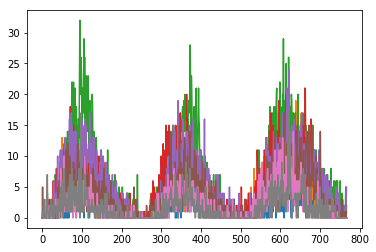

['haze',
 'agriculture',
 'clear',
 'water',
 'habitation',
 'road',
 'cultivation',
 'bare_ground']

In [32]:
xx = [0]+range(2,8)+[12] # плохие 600-4000
plt.plot(bstga[:,xx]); 
#plt.legenda([labels[x] for x in xx])
plt.show();
[labels[x] for x in xx]


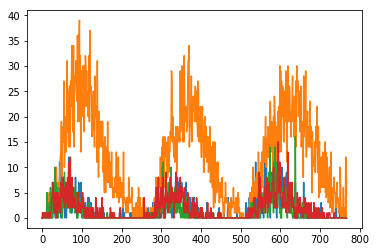

['slash_burn', 'partly_cloudy', 'blooming', 'selective_logging']

In [33]:
xx = [8,10,14,15] # среднии 100-400
plt.plot(bstga[:,xx]); 
#plt.legenda([labels[x] for x in xx])
plt.show();
[labels[x] for x in xx]


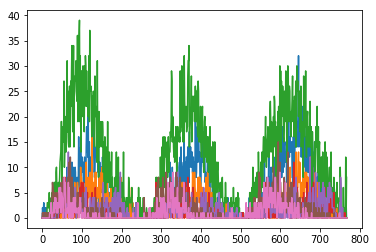

['primary',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'artisinal_mine',
 'selective_logging',
 'blow_down']

In [34]:
xx = [1,9,10,11,13,15,16] # отличные 0-100
plt.plot(bstga[:,xx]); plt.show();
[labels[x] for x in xx]

In [35]:
# Посчитать уровень прохождения для каждого признака
ixx, iacc = getTh(trY,trYPP)
np.array(ixx), iacc

(array([ 0.4 ,  0.52,  0.45,  0.56,  0.35,  0.37,  0.46,  0.37,  0.14,
         0.47,  0.24,  0.05,  0.26,  0.14,  0.18,  0.25,  0.2 ]),
 [(40.0, 0.97247955730131674, 0.97161491143555923, 1114, 1149),
  (52.0, 0.99918476246942856, 0.99906124163146326, 33, 38),
  (45.0, 0.93174238494033945, 0.93030954321994119, 2763, 2821),
  (56.0, 0.99276167889522959, 0.99164999135354137, 293, 338),
  (35.0, 0.94305689369796686, 0.92383705131055605, 2305, 3083),
  (37.0, 0.99281108723041578, 0.98935250376738559, 291, 431),
  (46.0, 0.93626324760987178, 0.93480570172188049, 2580, 2639),
  (37.0, 0.92509696385780282, 0.91763630524469475, 3032, 3334),
  (14.0, 1.0, 0.99977766249166233, 0, 9),
  (47.0, 0.99508387064897852, 0.99493564564342007, 199, 205),
  (24.0, 1.0, 1.0, 0, 0),
  (5.0, 1.0, 1.0, 0, 0),
  (26.0, 0.99152647051557596, 0.98705501618122982, 343, 524),
  (14.0, 1.0, 1.0, 0, 0),
  (18.0, 0.99718372489438967, 0.99476271647026848, 114, 212),
  (25.0, 0.99945650831295241, 0.99772721658143726, 22,

In [45]:
def convert0x5 (tPredict,cc) : # cc -> 0.5 подтягиваем ломаной
    temp0 = tPredict.copy()
    temp1 = tPredict.copy()
    aa = np.divide(0.5,(1.0-cc))
    bb = 1.0 - aa
    for i in range(cc.shape[0]) :
        temp0[tPredict[:,i]> cc[i],i] = 0.0
        temp1[tPredict[:,i]<=cc[i],i] = 0.0
        temp0[:,i] = 0.5/cc[i]*temp0[:,i]
        temp1[tPredict[:,i]>cc[i],i] = aa[i]*temp1[tPredict[:,i]>cc[i],i]+bb[i]
    return(temp0+temp1)

In [46]:
type(ixx)
trYZ = convert0x5(trYPP,np.array(ixx));
trYPP[0],trYZ[0],np.array(ixx)

(array([  6.58011138e-01,   9.90658760e-01,   8.67615826e-03,
          2.22895697e-01,   1.96270496e-02,   2.35312982e-04,
          7.85448030e-03,   8.23995844e-03,   2.78736174e-04,
          2.39000563e-03,   7.48114951e-04,   1.23488044e-05,
          3.71635030e-03,   7.80847586e-06,   4.05057974e-04,
          4.53088083e-04,   4.89163831e-05], dtype=float32),
 array([  7.15009272e-01,   9.90269482e-01,   9.64017585e-03,
          1.99014008e-01,   2.80386433e-02,   3.17990518e-04,
          8.53747874e-03,   1.11350790e-02,   9.95486276e-04,
          2.54255906e-03,   1.55857275e-03,   1.23488047e-04,
          7.14682741e-03,   2.78874140e-05,   1.12516095e-03,
          9.06176167e-04,   1.22290963e-04], dtype=float32),
 array([ 0.4 ,  0.52,  0.45,  0.56,  0.35,  0.37,  0.46,  0.37,  0.14,
         0.47,  0.24,  0.05,  0.26,  0.14,  0.18,  0.25,  0.2 ]))

In [ ]:
4.85e-5*0.5/0.2

In [ ]:
# Forming output dataset for predicting --> trOX, trOY
#del(trX)
#del(trY)

In [37]:
# Данные для объединения от jpg
trOX  = np.load('../Work/t-'+str(10000+binsData)+jpgtif+'-XX-test.npy')
trOY  = np.load('../Work/t-'+str(10000+binsData)+jpgtif+'-YY-test.npy')

In [38]:
#trOX = dfOX.values
#trOY = dfOX.index.values
trOX.shape,trOY.shape,trOY[0:10]

((61191, 768),
 (61191,),
 array(['test_10002', 'test_10003', 'test_10004', 'test_10005',
        'test_10006', 'test_10007', 'test_10008', 'test_10009', 'test_1001',
        'test_10010'], 
       dtype='|S10'))

In [39]:
# Формирование результата
dtest  = xgb.DMatrix(trOX)

In [40]:
trP = []
for bstI in bstList :
    trP1 = bstI.predict(dtest);
    trP.append(trP1)
trP = np.array(trP).T
type(trP),trP.shape    

(numpy.ndarray, (61191, 17))

In [41]:
#np.save('../Work/test-data-RR'+str(binsData)+ttExt+'.npy',trP)

In [42]:
#trP = np.load('../Work/test-data-RR'+str(binsData)+ttExt+'.npy')
#trP.shape

In [47]:
wr = [labels.index(i) for i in weather_labels];

trPZ = convert0x5(trP,np.array(ixx))
trM  = np.array([0.5]*trPZ.shape[1]);
#### Коэффициенты работают +0.01 к счету trM=np.array([0.5]*17);
trM[np.array(wr)] = 2.0

res = []

for i in range(trPZ.shape[0]) :
    trA1 = [weather_labels[trPZ[i,wr].argmax()]]
    trA2 = [labels[ii] for ii in range(len(labels)) if (trPZ[i,ii]>trM[ii])]
    if trA1[0]=='cloudy' : trA2 = []
    ##trPP = trA1 + trA2;
    pp   = ' '.join(trA1+trA2)
    ##if (pp=="") : print(trY[i])
    res.append([trOY[i],pp])

res.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))
#print(res[4:8],'\n',res[-4:])

In [48]:
print(wr,'\n',labels)
print(res[0],'\n',res[-1],'\n',trM,trPZ[0],trPZ[-1])

[3, 10, 0, 9] 
 ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']
['test_0', 'clear primary'] 
 ['file_20521', 'clear primary'] 
 [ 2.   0.5  0.5  2.   0.5  0.5  0.5  0.5  0.5  2.   2.   0.5  0.5  0.5  0.5
  0.5  0.5] [  1.71211377e-01   9.84483808e-02   5.36737218e-02   1.51608065e-01
   4.43287253e-01   7.99778558e-04   1.90084409e-02   7.43901171e-03
   7.99970658e-05   8.56351554e-01   6.45699503e-04   4.39817595e-05
   8.23747087e-03   4.76127752e-05   3.03096895e-04   2.50399113e-04
   5.99584528e-05] [  2.81391619e-03   8.10180008e-01   1.89020351e-01   9.91853356e-01
   2.83924818e-01   9.95300114e-01   9.78598237e-01   5.64583652e-02
   7.21995675e-05   1.20801860e-02   1.85019433e-01   3.86089698e-04
   1.26340007e-02   6.87920765e-05   3.47485766e-04   7.15399365e-05
   3.45977169e-05]


In [50]:
temp=trPZ[:,wr].argmax(axis=1); pd.Series(temp).groupby(temp).count()

0    43451
1    11127
2     3579
3     3034
dtype: int64

In [86]:
temp=trP[:,wr].argmax(axis=1); pd.Series(temp).groupby(temp).count()

0    44164
1    10531
2     3337
3     3159
dtype: int64

In [51]:
print(labels)
print(trM.tolist())
#np.round(trP[4:11,:])

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']
[2.0, 0.5, 0.5, 2.0, 0.5, 0.5, 0.5, 0.5, 0.5, 2.0, 2.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


In [52]:
rrr=pd.DataFrame(res,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-07-04-10-09-31
